# Generate null brain maps for significance testing

This tutorial demonstrates how to use the eigenstrapping framework, developed by [Koussis *et al.* (2025)](https://doi.org/10.1162/IMAG.a.71), to generate null distributions for statistical analysis of associations between brain annotations. 

A null map, $y'(\vec{r})$, is generated according to the following equation:

$$y'(\vec{r})=\sum\limits_{\Lambda=0}^G\sum\limits_{\mu=-\Lambda}^\Lambda\bigg(\beta_{\Lambda\mu}\psi'_{\Lambda\mu}(\vec{r})\bigg)+\epsilon(\vec{r})$$

where:
- $\Lambda$ denotes the eigengroup
- $\mu$ denotes the eigenmode within the eigengroup
- $G$ is the maximum eigengroup
- $\beta_{\Lambda\mu}$ are the coefficients obtained by decomposing the original map onto the eigenmodes
- $\psi'_{\Lambda\mu}(\vec{r})$ are the new eigenmodes from the rotated eigengroup
- $\epsilon(\vec{r})$ is the residual term

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from importlib.resources import files, as_file
from neuromodes import EigenSolver
from neuromodes.io import fetch_surf, fetch_map
from nsbutils.plotting import plot_surf
from nsbutils.utils import unmask

In [2]:
# Configuration
density = '32k'
n_modes = 15**2   # First 15 eigengroups
n_nulls = 1000
seed = 365

We start by loading a mesh, initiating the `EigenSolver` class, and computing the eigenmodes.

In [3]:
mesh, medmask = fetch_surf(density=density, hemi='L', surf_type='midthickness')
myelinmap = fetch_map('myelinmap', density=density)[medmask]

solver = EigenSolver(mesh, mask=medmask).solve(n_modes)

We can then call the `eigenstrap` class method to generate a null distribution. This may take a few minutes depending on the number of CPU cores available.

In [4]:
# Calculate nulls
nulls = solver.eigenstrap(
    data=myelinmap,
    n_nulls=n_nulls,
    seed=seed,
    randomize=False,
    resample=None,
    n_jobs=-1   # Use all available CPU cores for parallel processing
)
print(nulls.shape)

(29696, 1000)


Now let's visualize the original map and a few null maps.

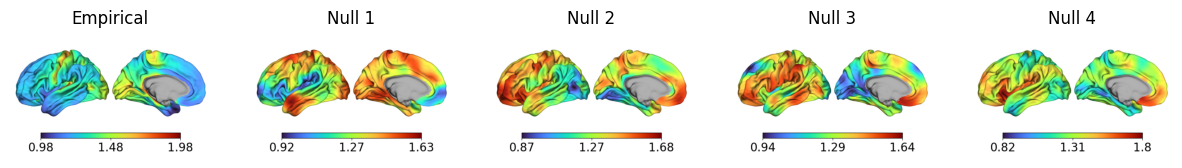

In [5]:
# Plot nulls
lh_surfpath = files('neuromodes.data') / f'sp-human_tpl-fsLR_den-{density}_hemi-L_midthickness.surf.gii'

with as_file(lh_surfpath) as lh_surfpath:
    fig1, axs = plt.subplots(1, 5, figsize=(15, 6))
    axs = axs.ravel()
    for i, ax_i in enumerate(axs):
        if i == 0:
            data = unmask(myelinmap, medmask)
            title = "Empirical"
        else:
            data = unmask(nulls[:, i-1], medmask)
            title = f"Null {i}"

        color_range = (np.nanpercentile(data, 5), np.nanpercentile(data, 95))

        plot_surf(lh_surfpath, data, cmap='turbo', color_range=color_range, ax=axs[i], cbar=True)
        axs[i].set_title(title)

We can check that the power spectrum distribution between the original and the nulls is approximately preserved on the cortex (it will exactly preserved only on surfaces where the group relationship is exact i.e. the sphere). 

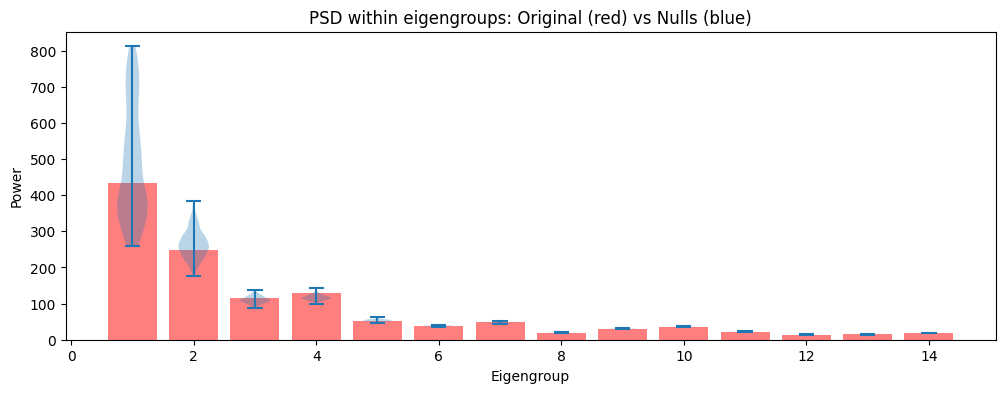

In [6]:
# PSD within each eigengroup should be approximately preserved
group_indices = np.floor(np.sqrt(np.arange(n_modes))).astype(int)
n_groups = group_indices.max() + 1

beta0 = solver.decompose(myelinmap)
psd0 = np.bincount(group_indices, weights=beta0.ravel()**2)

beta1 = solver.decompose(nulls)
psd1 = np.array([np.bincount(group_indices, weights=beta1[:, i].ravel()**2) for i in range(n_nulls)])


fig, axs = plt.subplots(figsize=(12,4))
axs.bar(range(1,n_groups), psd0[1:], color='red', alpha=0.5)
axs.violinplot(psd1[:,1:], positions=range(1,n_groups))
axs.set_title("PSD within eigengroups: Original (red) vs Nulls (blue)")
axs.set_xlabel("Eigengroup")
axs.set_ylabel("Power")
plt.show()

Let's also plot the distribution of correlation coefficients between every pair of null maps.

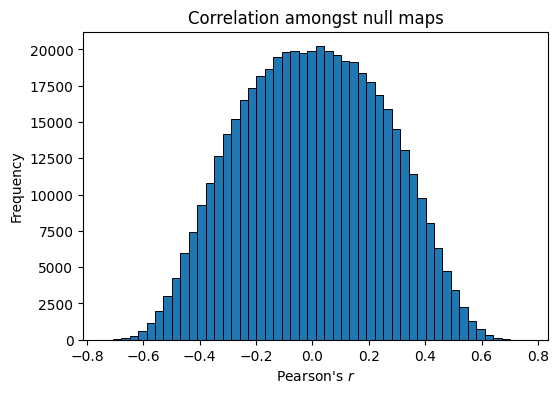

In [7]:
# Plot null correlation distribution
inter_null_corrs = np.corrcoef(nulls.T)
triu_inds = np.triu_indices_from(inter_null_corrs, k=1)
fig2, ax2 = plt.subplots(figsize=(6, 4))
ax2.hist(inter_null_corrs[triu_inds], bins=50, edgecolor='black', linewidth=0.7)
ax2.set_title("Correlation amongst null maps")
ax2.set_xlabel("Pearson's $r$")
ax2.set_ylabel("Frequency")

plt.show()

Now we can use our nulls to test whether the myelinmap is significantly correlated with the principal gradient of functional connectivity ([Margulies *et al.* (2016)](https://doi.org/10.1073/pnas.1608282113)).

Observed correlation between myelinmap and fcgradient1: -0.5262
p-value: 0.0020


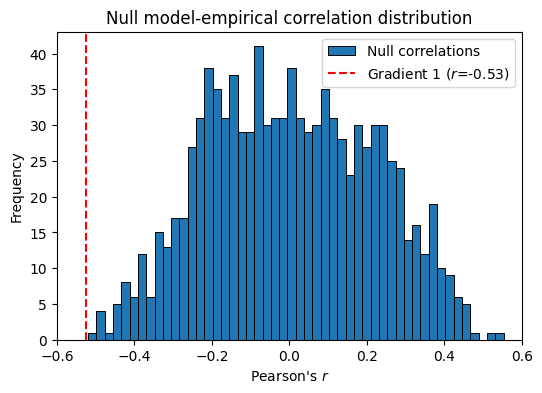

In [8]:
fcgrad = fetch_map('fcgradient1', density=density)[medmask]

# Compute correlation between myelinmap and fcgradient1
corr = np.corrcoef(myelinmap, fcgrad)[0, 1]

# Compute correlation between myelinmap and nulls
null_corrs = np.corrcoef(myelinmap, nulls, rowvar=False)[0, 1:]

pvalue = (np.sum(np.abs(null_corrs) >= np.abs(corr)) + 1) / (n_nulls + 1)
print(f"Observed correlation between myelinmap and fcgradient1: {corr:.4f}")
print(f"p-value: {pvalue:.4f}")

# Plot correlation distributions
fig, ax_i = plt.subplots(figsize=(6, 4))
ax_i.hist(null_corrs, bins=50, edgecolor='black', linewidth=0.7, label='Null correlations')
ax_i.axvline(corr, color='red', linestyle='--', label=f'Gradient 1 ($r$={corr:.2f})')
ax_i.set_title("Null model-empirical correlation distribution")
ax_i.set_xlabel("Pearson's $r$")
ax_i.set_ylabel("Frequency")
ax_i.set_xlim(-0.6, 0.6)
ax_i.legend()
plt.show()